In [ ]:
'''
    Author: Ashish Kumar

'''

In [18]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
train_path = './train.csv'
test_path = './test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [40]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [41]:
df_train.groupby('target').count()

,qid,question_text
target,,
0,1225312,1225312
1,80810,80810


In [42]:
df_train.where(df_train['target'] == 1).dropna()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1.0
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1.0
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1.0
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1.0
115,000537213b01fd77b58a,Which races have the smallest penis?,1.0
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1.0
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1.0
144,00068875d7c82a5bcf88,Why do Europeans say they're the superior race...,1.0
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on...,1.0
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1.0


In [43]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [44]:
df_train['question_text'][130757]

'What are the literary devices used in the novel "Les Misérables" by Victor Hugo?'

[Text(0.5, 0, 'Target')]

[Text(0, 0.5, 'count')]

Text(0.5, 1.0, 'Distribution of Negative & Positive Insincere question')

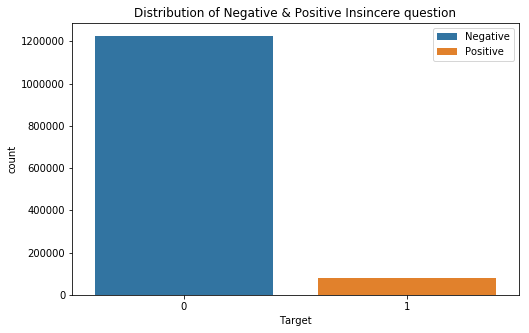

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df_train.target.unique(),y=df_train.target.value_counts(), hue = ['0', '1'], dodge = False);

#ax.set_title('Distribution of Negative & Positive Insincere question')
ax.set(xlabel= 'Target')
ax.set(ylabel= 'count')

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Negative', 'Positive'])

plt.title('Distribution of Negative & Positive Insincere question')
plt.show()

In [46]:
print(type(df_train['question_text']))
# df_train['question_text'] = df_train.question_text.progress_apply(lambda x: re.sub('\n', ' ', x))


<class 'pandas.core.series.Series'>


In [47]:
df_train['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [48]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])

def tweet_clean(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text) # remove the line breaker in each question
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text

def tokenizer(s):
    return nlp(tweet_clean(s))

In [49]:
#df_sample= pd.read_csv('train.csv')
df_train['question_text'] = df_train.question_text.progress_apply(lambda x: tweet_clean(x))
# df_train = df_train[df_train['question_text'].map(len) > 8].reset_index(drop = True)

Progress: 100%|██████████| 1306122/1306122 [00:14<00:00, 87317.54it/s]


In [50]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [51]:
# df_train['question_text'] = df_train['question_text'].str.split()
split_train = df_train

In [52]:
split_train['question_text'] = df_train['question_text'].str.split()
split_train.head()

,qid,question_text,target
0,00002165364db923c7e6,"[how, did, quebec, nationalists, see, their, p...",0
1,000032939017120e6e44,"[do, you, have, an, adopted, dog, how, would, ...",0
2,0000412ca6e4628ce2cf,"[why, does, velocity, affect, time, does, velo...",0
3,000042bf85aa498cd78e,"[how, did, otto, von, guericke, used, the, mag...",0
4,0000455dfa3e01eae3af,"[can, i, convert, montra, helicon, d, to, a, m...",0


In [53]:
# mask = (split_train['question_text'].str.len() <= 1)
# print(split_train.loc(mask))
split_df = split_train[split_train['question_text'].map(len) > 1].reset_index(drop=True)

In [54]:
split_df.head()

,qid,question_text,target
0,00002165364db923c7e6,"[how, did, quebec, nationalists, see, their, p...",0
1,000032939017120e6e44,"[do, you, have, an, adopted, dog, how, would, ...",0
2,0000412ca6e4628ce2cf,"[why, does, velocity, affect, time, does, velo...",0
3,000042bf85aa498cd78e,"[how, did, otto, von, guericke, used, the, mag...",0
4,0000455dfa3e01eae3af,"[can, i, convert, montra, helicon, d, to, a, m...",0


In [55]:
split_df['question_text'] = split_df['question_text'].str.join(sep=' ')

In [56]:
split_df.head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [57]:
df_train = split_df

In [58]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [ ]:
## seperating

In [59]:
def split_train_test(df_train, test_size=0.2):
    train, val = train_test_split(df_train, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [60]:
traindf, valdf = split_train_test(df_train, test_size=0.2)

In [61]:
traindf.to_csv('traindf.csv', index = False)
valdf.to_csv('valdf.csv',index= False)

In [62]:
# Data Cleaning

In [63]:
def splitter(x): return x.split()

TEXT = data.Field(sequential=True, tokenize=splitter, include_lengths=True, use_vocab=True)
LABELS = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_fields = [
    ('qid', None),
    ('question_text', TEXT),
    ('target', LABELS)
]

In [64]:
%%time
trainds, valds = data.TabularDataset.splits(path='./', 
                                            format='csv', train='traindf.csv', validation='valdf.csv', 
                                            fields=train_fields, skip_header=True)

CPU times: user 19.8 s, sys: 15.1 s, total: 34.9 s
Wall time: 36.9 s


In [65]:
type(trainds)
len(trainds), len(valds)
trainds[0].question_text

torchtext.data.dataset.TabularDataset

(1044875, 261219)

['how',
 'would',
 'a',
 'cfa',
 'help',
 'if',
 'i',
 'plan',
 'on',
 'pursuing',
 'mba',
 'after',
 'ca',
 'how',
 'to',
 'do',
 'it',
 'as',
 'i',
 'have',
 'just',
 'cleared',
 'ipcc']

In [66]:
ex = trainds.examples[0]
type(ex)
trainds.fields.items()
ex.question_text
ex.target

torchtext.data.example.Example

dict_items([('qid', None), ('question_text', <torchtext.data.field.Field object at 0x1afda2e438>), ('target', <torchtext.data.field.Field object at 0x1afda2e518>)])

['how',
 'would',
 'a',
 'cfa',
 'help',
 'if',
 'i',
 'plan',
 'on',
 'pursuing',
 'mba',
 'after',
 'ca',
 'how',
 'to',
 'do',
 'it',
 'as',
 'i',
 'have',
 'just',
 'cleared',
 'ipcc']

'0'

### Load pretrained word vectors and building vocabulary

In [67]:
%%time
vec = vocab.Vectors('word2vec.txt', './')


CPU times: user 164 ms, sys: 177 ms, total: 341 ms
Wall time: 510 ms


In [68]:
len(vec.vectors)

258110

In [69]:
%%time
TEXT.build_vocab(trainds, valds, max_size=len(vec.vectors), vectors=vec)
LABELS.build_vocab(trainds)

CPU times: user 12.8 s, sys: 265 ms, total: 13 s
Wall time: 13.1 s


In [70]:
TEXT.vocab.vectors.shape

torch.Size([192520, 50])

In [71]:
TEXT.vocab.vectors[TEXT.vocab.stoi['a']]

tensor([-1.4315, -2.6598,  0.4538, -0.4569,  1.1227,  0.2325, -0.2207,  2.3917,
        -2.2225,  1.6792, -0.8594,  1.1664,  0.8578,  0.0004, -1.2418, -3.3718,
         0.9664,  1.0759,  5.0070,  1.2052,  1.0962,  2.0620,  1.5243,  1.4128,
        -2.3810,  3.3441, -1.6822, -0.2576, -1.1957,  1.3121,  2.7869,  3.1460,
         1.5586,  0.4723,  1.2427,  0.6243, -1.7932, -3.9185,  2.2868, -2.0155,
         3.8783, -2.0760, -1.8423, -0.2244,  3.4017, -2.4928, -2.1677,  0.8344,
         3.0949, -3.1904])

0

In [72]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.question_text), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [73]:
len(traindl), len(valdl)

(348292, 87073)

In [74]:
batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [75]:
len(traindl), len(valdl)

(348292, 87073)

In [76]:
batch.target

tensor([0, 0, 0])

In [77]:
batch.question_text


(tensor([[   27,     3, 49533],
         [    5,     2,   856],
         [  856,   427,   256],
         [18625,    29,   455],
         [  240,     8,     4],
         [  987,  1207,    36],
         [    5,   971,  3226],
         [ 4625,   134,   445]]), tensor([8, 8, 8]))

In [78]:
batch.dataset.fields

{'qid': None,
 'question_text': <torchtext.data.field.Field at 0x1afda2e438>,
 'target': <torchtext.data.field.Field at 0x1afda2e518>}

In [79]:
TEXT.vocab.itos[1]

'<pad>'

## Function to convert batch to text

In [80]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.question_text[0][:,idx].cpu().data.numpy()])

In [81]:
idxtosent(batch,0)

'does a strong typhoon always result a disaster'

In [82]:
val_batch = next(iter(valdl))
val_batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1afed24b38>,
 'fields': dict_keys(['qid', 'question_text', 'target']),
 'input_fields': ['question_text', 'target'],
 'target_fields': [],
 'question_text': (tensor([[    3, 13107,  6396],
          [ 2566, 13107,   681]]), tensor([2, 2, 2])),
 'target': tensor([0, 1, 1])}

##### Note that BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. 
##### This is one of the small hiccups in torchtext. But this can be easily overcome in two ways. Either write some extra code in the training loop for getting the data out of Batch object or write a iterable wrapper around Batch Object that returns the desired data. I will take the second approach as this is much cleaner.

In [83]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [84]:
train_batch_it = BatchGenerator(traindl, 'question_text', 'target')
next(iter(train_batch_it))

((tensor([[   10,    10,     4],
          [   71,    27,    18],
          [   39,     5,   293],
          [    7,  1170,     6],
          [   60,  6592,    65],
          [   45,    24, 10076],
          [29036,   262,     7],
          [18089,  1171,    59],
          [   11,  3513,   105],
          [99908,   106,    23],
          [77593,   419,  7961]]), tensor([11, 11, 11])), tensor([0, 0, 0]))

## Train 

In [85]:
vocab_size = len(TEXT.vocab)
embedding_dim = 50
n_hidden = 64
n_out = 2

In [86]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

In [87]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

In [88]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), batch_sizes=(512,1024), sort_key=lambda x: len(x.question_text), device=0, sort_within_batch=True, repeat=False)
train_batch_it = BatchGenerator(traindl, 'question_text', 'target')
val_batch_it = BatchGenerator(valdl, 'question_text', 'target')

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [89]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['question_text'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)

Epoch 0: train_loss: 0.1516 train_acc: 0.9447 | val_loss: 0.1357 val_acc: 0.9496


Epoch 1: train_loss: 0.1329 train_acc: 0.9497 | val_loss: 0.1294 val_acc: 0.9514


Epoch 2: train_loss: 0.1279 train_acc: 0.9511 | val_loss: 0.1275 val_acc: 0.9523


Epoch 3: train_loss: 0.1247 train_acc: 0.9523 | val_loss: 0.1311 val_acc: 0.9512


Epoch 4: train_loss: 0.1223 train_acc: 0.9531 | val_loss: 0.1242 val_acc: 0.9529

